In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
from glob import glob
from yolov3.yolov4_config import Create_Yolo
from yolov3.utils_config import load_yolo_weights, detect_image, image_preprocess, postprocess_boxes_excel, nms, draw_bbox
from yolov3.configs_config import *
from PIL import Image

import os
import pandas as pd

if YOLO_TYPE == "yolov4":
    Darknet_weights = YOLO_V4_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V4_WEIGHTS
if YOLO_TYPE == "yolov3":
    Darknet_weights = YOLO_V3_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V3_WEIGHTS

yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE)
load_yolo_weights(yolo, Darknet_weights) # use Darknet weights

In [2]:
yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=TRAIN_CLASSES)
yolo.load_weights("./checkpoints/frist/yolov3_custom") # use keras weights

In [3]:
def prt_loss(image_path ,yolo):
    input_size = 416
    iou_threshold = 0.45
    
    original_image      = cv2.imread(image_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    pred_bbox = yolo.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes, pred_coor, pred_conf, pred_prob  = postprocess_boxes_excel(pred_bbox, original_image, input_size, 0.0)
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    argmax_score = np.argmax(scores)
    max_score = np.max(scores)
    print_conf, print_prob = pred_conf[argmax_score], pred_prob[argmax_score]
    
    return [max_score, print_conf, np.float(print_prob)]

In [4]:
def GIoU(bboxes_1, bboxes_2):
    # 1. calulate intersection over union
    area_1 = (bboxes_1[2] - bboxes_1[0]) * (bboxes_1[3] - bboxes_1[1])
    area_2 = (bboxes_2[2] - bboxes_2[0]) * (bboxes_2[3] - bboxes_2[1])
    
    intersection_wh = tf.minimum(bboxes_1[2:], bboxes_2[2:]) - tf.maximum(bboxes_1[ :2], bboxes_2[ :2])
    intersection_wh = tf.maximum(intersection_wh, 0)
    
    intersection = intersection_wh[0] * intersection_wh[1]
    union = (area_1 + area_2) - intersection
    
    ious = intersection / union
    
    # 2. (C - (A U B))/C
    C_wh = tf.maximum(bboxes_1[2:], bboxes_2[2:]) - tf.minimum(bboxes_1[:2], bboxes_2[:2])
    C_wh = C_wh
    C = C_wh[0] * C_wh[1]

    giou = ious - (C - union) / C
    return giou, ious

In [5]:
r1 = glob(r"teeth_including_lip_more\test/*.jpg")

In [6]:
r11 = glob(r"teeth_including_lip_more\train/*.jpg")

In [7]:
r5 = glob(r"C:\Users\NA_team_1\Desktop\test\*.jpg")

In [8]:
coco_anomaly =  glob(r"C:\Users\NA_team_1\Desktop\val2017\*.jpg")
np.random.seed(42)
a = np.random.randint(5000, size =76)
a = np.sort(a)
print(a)
anomaly_76 = [coco_anomaly[i] for i in a]

[  34  130  161  189  241  337  466  474  600  646  769  775  860  878
  975  995 1016 1021 1076 1082 1184 1267 1275 1363 1478 1500 1528 1585
 1685 1806 1899 1955 1981 2041 2047 2061 2363 2391 2433 2435 2556 2558
 2612 2613 2734 2747 2824 2888 2904 2919 3005 3073 3092 3152 3171 3202
 3342 3385 3444 3461 3556 3772 3798 3843 3890 3943 4014 4117 4297 4426
 4551 4555 4658 4798 4843 4911]


In [9]:
r2 =  glob(r"C:\Users\NA_team_1\Desktop\GitHub\TensorFlow-2.x-YOLOv3\anomaly_data/*.jpg")

In [10]:
anomaly_85 = anomaly_76 + r2[-9:]

In [11]:
angled_path = r"C:\Users\NA_team_1\Desktop\GitHub\TensorFlow-2.x-YOLOv3\angled"

In [12]:
brace_path = r"braces"

In [13]:
angled_path = r"angled"

### pred score save 

In [14]:
train_names = []
valid_names = []
test_names = []
anomaly_names = []

In [15]:
coco_names = []
braces_names = []
angle_names = []

In [16]:
for i in range(len(r11)):
    train_names.append(os.path.basename(r11[i]))
for i in range(len(r1)):
    valid_names.append(os.path.basename(r1[i]))
for i in range(len(r1)):
    test_names.append(os.path.basename(r5[i]))
for i in range(len(anomaly_85)):
    anomaly_names.append(os.path.basename(anomaly_85[i]))

In [17]:
for i in range(len(coco_anomaly)):
    coco_names.append(os.path.basename(coco_anomaly[i]))
for i in range(len(os.listdir(brace_path))):
    braces_names.append(os.path.basename(os.listdir(brace_path)[i]))
for i in range(len(os.listdir(angled_path))):
    angle_names.append(os.path.basename(os.listdir(angled_path)[i]))

In [18]:
train_score = []
valid_score = []
test_score = []
anomaly_score = []

In [19]:
coco_score = []
braces_score = []
angle_score = []

In [20]:
for i in range(len(r11)):
    aa =prt_loss(r11[i] ,yolo)
    train_score.append(aa)

In [21]:
for i in range(len(r1)):
    aa =prt_loss(r1[i] ,yolo)
    valid_score.append(aa)

In [22]:
for i in range(len(r5)):
    aa =prt_loss(r5[i] ,yolo)
    test_score.append(aa)

In [23]:
for i in range(len(anomaly_85)):
    aa =prt_loss(anomaly_85[i] ,yolo)
    anomaly_score.append(aa)

In [24]:
raw_training = pd.DataFrame(data=np.array(train_score), index=[train_names], columns=["score","pred_conf","pred_prob"])

In [25]:
raw_valid = pd.DataFrame(data=np.array(valid_score), index=[valid_names], columns=["score","pred_conf","pred_prob"])

In [26]:
raw_test = pd.DataFrame(data=np.array(test_score), index=[test_names], columns=["score","pred_conf","pred_prob"])

In [27]:
raw_anomaly = pd.DataFrame(data=np.array(anomaly_score), index=[anomaly_names], columns=["score","pred_conf","pred_prob"])

In [28]:
for i in range(len(coco_anomaly)):
    aa =prt_loss(coco_anomaly[i] ,yolo)
    coco_score.append(aa)

In [29]:
for i in range(len(os.listdir(angled_path))):
    aa =prt_loss(os.path.join(angled_path, os.listdir(angled_path)[i]) ,yolo)
    angle_score.append(aa)

In [30]:
for i in range(len(os.listdir(brace_path))):
    aa =prt_loss(os.path.join(brace_path, os.listdir(brace_path)[i]) ,yolo)
    braces_score.append(aa)

In [31]:
raw_coco= pd.DataFrame(data=np.array(coco_score), index=[coco_names], columns=["score","pred_conf","pred_prob"])

In [32]:
raw_anlge= pd.DataFrame(data=np.array(angle_score), index=[angle_names], columns=["score","pred_conf","pred_prob"])

In [33]:
raw_braces= pd.DataFrame(data=np.array(braces_score), index=[braces_names], columns=["score","pred_conf","pred_prob"])

## GIOU(must change when change txt file)

In [34]:
file = open("model_data/lip_more_train.txt", "r")
no_lip_train = file.readlines()
file.close()
file = open("model_data/lip_more_validation.txt", "r")
no_lip_valid = file.readlines()
file.close()

In [35]:
GT_train = []
GT_valid = []

In [36]:
giou_ious_list_train = []
giou_ious_list_valid = []

In [37]:
#GT add
for i in range(len(r11)):
    bb = no_lip_train[i].split()[1].split(",")[0:4]
    bb = [int(item) for item in bb]
    GT_train.append(bb)
for i in range(len(r1)):
    bb = no_lip_valid[i].split()[1].split(",")[0:4]
    bb = [int(item) for item in bb]
    GT_valid.append(bb)

In [38]:
# train
for i in range(len(r11)):
    image, bboxes = detect_image(yolo, r11[i], "", input_size=YOLO_INPUT_SIZE, show=False, score_threshold=0.1, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
    if len(bboxes) == 0 :
        giou_ious_list_train.append([0,0])
    else :
        giou,ious = GIoU(np.array(GT_train[i]), bboxes[0][:4])
        giou_ious_list_train.append([giou,ious])

In [39]:
# validation
for i in range(len(r1)):
    image, bboxes = detect_image(yolo, r1[i], "", input_size=YOLO_INPUT_SIZE,score_threshold=0.1, show=False, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
    if len(bboxes) == 0 :
        giou_ious_list_valid.append([0,0])
    else :
        giou,ious = GIoU(np.array(GT_valid[i]), bboxes[0][:4])
        giou_ious_list_valid.append([giou,ious])

In [40]:
raw_training_giou = pd.DataFrame(data=np.array(giou_ious_list_train), index=[train_names], columns=["giou", "iou"])

In [41]:
raw_valid_giou = pd.DataFrame(data=np.array(giou_ious_list_valid), index=[valid_names], columns=["giou", "iou"])

In [42]:
df_training_join = pd.merge(raw_training,raw_training_giou, left_index=True, right_index = True, 
                         how ="outer" )

In [43]:
df_valid_join = pd.merge(raw_valid,raw_valid_giou, left_index=True, right_index = True, 
                         how ="outer" )

In [44]:
xlxs_dir='___final.xlsx' #경로 및 파일명 설정
with pd.ExcelWriter(xlxs_dir) as writer:
    df_training_join.to_excel(writer, sheet_name = 'training_data') #raw_data1 시트에 저장
    df_valid_join.to_excel(writer, sheet_name = 'valid_data') #raw_data2 시트에 저장
    raw_test.to_excel(writer, sheet_name = 'test_data') #raw_data2 시트에 저장
    raw_anomaly.to_excel(writer, sheet_name = 'anomaly_data') #raw_data2 시트에 저장
    raw_coco.to_excel(writer, sheet_name = 'coco_data') #raw_data1 시트에 저장
    raw_anlge.to_excel(writer, sheet_name = 'angle_data') #raw_data2 시트에 저장
    raw_braces.to_excel(writer, sheet_name = 'braces_data') #raw_data2 시트에 저장

#  test2 replace old_test_set

In [45]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [46]:
train_df =  pd.read_excel("___final.xlsx", sheet_name="training_data", engine='openpyxl', index_col=0)
valid_df = pd.read_excel("___final.xlsx", sheet_name="valid_data", engine='openpyxl', index_col=0)
# test_df = pd.read_excel("___final.xlsx", sheet_name="test_data", engine='openpyxl', index_col=0)
anomaly_df = pd.read_excel("___final.xlsx", sheet_name="anomaly_data", engine='openpyxl', index_col=0)
coco_df = pd.read_excel("___final.xlsx", sheet_name="coco_data", engine='openpyxl', index_col=0)
angle_df = pd.read_excel("___final.xlsx", sheet_name="angle_data", engine='openpyxl', index_col=0)
braces_df = pd.read_excel("___final.xlsx", sheet_name="braces_data", engine='openpyxl', index_col=0)

In [47]:
test2  =glob(r"C:\Users\NA_team_1\Desktop\test2/*.jpg")
test_names = []
for i in range(len(test2)):
    test_names.append(os.path.basename(test2[i]))

test_score = []
for i in range(len(test2)):
    aa =prt_loss(test2[i] ,yolo)
    test_score.append(aa)


In [48]:
test2_df = pd.DataFrame(data=np.array(test_score), index=[test_names], columns=["score","pred_conf","pred_prob"])

In [49]:
xlxs_dir='___final_2.xlsx' #경로 및 파일명 설정
with pd.ExcelWriter(xlxs_dir) as writer:
    train_df.to_excel(writer, sheet_name = 'training_data') #raw_data1 시트에 저장
    valid_df.to_excel(writer, sheet_name = 'valid_data') #raw_data2 시트에 저장
    test2_df.to_excel(writer, sheet_name = 'test_data') #raw_data2 시트에 저장
    anomaly_df.to_excel(writer, sheet_name = 'anomaly_data') #raw_data2 시트에 저장
    coco_df.to_excel(writer, sheet_name = 'coco_data') #raw_data1 시트에 저장
    angle_df.to_excel(writer, sheet_name = 'angle_data') #raw_data2 시트에 저장
    braces_df.to_excel(writer, sheet_name = 'braces_data') #raw_data2 시트에 저장

# remove overlab

In [50]:
from glob import glob
import numpy as np
import pandas as pd
import os

In [51]:
coco_anomaly =  glob(r"C:\Users\NA_team_1\Desktop\val2017\*.jpg")
np.random.seed(42)
a = np.random.randint(5000, size =76)
a = np.sort(a)
print(a)
anomaly_76 = [coco_anomaly[i] for i in a]

[  34  130  161  189  241  337  466  474  600  646  769  775  860  878
  975  995 1016 1021 1076 1082 1184 1267 1275 1363 1478 1500 1528 1585
 1685 1806 1899 1955 1981 2041 2047 2061 2363 2391 2433 2435 2556 2558
 2612 2613 2734 2747 2824 2888 2904 2919 3005 3073 3092 3152 3171 3202
 3342 3385 3444 3461 3556 3772 3798 3843 3890 3943 4014 4117 4297 4426
 4551 4555 4658 4798 4843 4911]


In [52]:
train_df =  pd.read_excel("___final_2.xlsx", sheet_name="training_data", engine='openpyxl', index_col=0)
valid_df = pd.read_excel("___final_2.xlsx", sheet_name="valid_data", engine='openpyxl', index_col=0)
test2_df = pd.read_excel("___final_2.xlsx", sheet_name="test_data", engine='openpyxl', index_col=0)
anomaly_df = pd.read_excel("___final_2.xlsx", sheet_name="anomaly_data", engine='openpyxl', index_col=0)
coco_df = pd.read_excel("___final_2.xlsx", sheet_name="coco_data", engine='openpyxl', index_col=0)
angle_df = pd.read_excel("___final_2.xlsx", sheet_name="angle_data", engine='openpyxl', index_col=0)
braces_df = pd.read_excel("___final_2.xlsx", sheet_name="braces_data", engine='openpyxl', index_col=0)

In [53]:
remove_name = [os.path.basename(i) for i in anomaly_76]
coco_df = coco_df.drop(remove_name)

In [54]:
xlxs_dir='___final_3.xlsx' #경로 및 파일명 설정
with pd.ExcelWriter(xlxs_dir) as writer:
    train_df.to_excel(writer, sheet_name = 'training_data') #raw_data1 시트에 저장
    valid_df.to_excel(writer, sheet_name = 'valid_data') #raw_data2 시트에 저장
    test2_df.to_excel(writer, sheet_name = 'test_data') #raw_data2 시트에 저장
    anomaly_df.to_excel(writer, sheet_name = 'anomaly_data') #raw_data2 시트에 저장
    coco_df.to_excel(writer, sheet_name = 'coco_data') #raw_data1 시트에 저장
    angle_df.to_excel(writer, sheet_name = 'angle_data') #raw_data2 시트에 저장
    braces_df.to_excel(writer, sheet_name = 'braces_data') #raw_data2 시트에 저장

# AUC 계산

In [55]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [56]:
test_df = pd.read_excel("___final_3.xlsx", sheet_name="test_data", engine='openpyxl')
# anomaly_df = pd.read_excel("___final_3.xlsx", sheet_name="anomaly_data", engine='openpyxl')
coco_df = pd.read_excel("___final_3.xlsx", sheet_name="coco_data", engine='openpyxl')
angle_df = pd.read_excel("___final_3.xlsx", sheet_name="angle_data", engine='openpyxl')
braces_df = pd.read_excel("___final_3.xlsx", sheet_name="braces_data", engine='openpyxl')

In [57]:
test_pred_score = [i for i in test_df["score"]]
# anomaly_pred_score = [i for i in anomaly_df["score"]]
coco_pred_score=  [i for i in coco_df["score"]]
angle_pred_score =  [i for i in angle_df["score"]]
braces_pred_score =  [i for i in braces_df["score"]]

In [58]:
y = [1]*len(test_pred_score) +  [0]*len(coco_pred_score)+ [0]*len(angle_pred_score) +[1]*len(braces_pred_score)

In [59]:
pred = np.array(test_pred_score +coco_pred_score +angle_pred_score+braces_pred_score)

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)

In [61]:
print(roc_auc)

0.9978632407144991


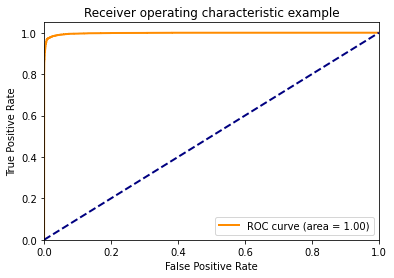

In [62]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [63]:
for i in range(len(pred)):
    if pred[i]>0.8 :
        pred[i]=1
    else:
        pred[i]=0

In [64]:
tn, fp, fn, tp = metrics.confusion_matrix(y, pred).ravel()
(tn, fp, fn, tp)

(4644, 295, 38, 4985)

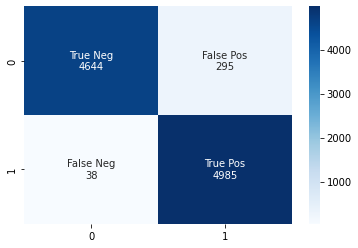

In [65]:
import seaborn as sns
cf_matrix = metrics.confusion_matrix(y, pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = [“{0:.2%}”.format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2  in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.savefig("confusion_matrix.jpg",bbox_inches = "tight")